# Nota

Notebook feito no Colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Imports

In [ ]:
from itertools import product
from typing import Sequence

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from ipywidgets import FloatLogSlider, interact
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, StandardScaler

In [ ]:
print(pd.__version__)
print(sns.__version__)

2.0.3
0.13.1


# Helper Functions

In [ ]:
root_mean_squared_error = lambda a, b: np.sqrt(np.mean((a - b)**2))

# Carregamento dos dados e EDA inicial

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/UFSC/EEL7514/datasets/cars.csv")
df.head()

,manufacturer_name,model_name,transmission,color,odometer_value,year_produced,engine_fuel,engine_has_gas,engine_type,engine_capacity,...,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,duration_listed
0,Subaru,Outback,automatic,silver,190000,2010,gasoline,False,gasoline,2.5,...,True,True,True,False,True,False,True,True,True,16
1,Subaru,Outback,automatic,blue,290000,2002,gasoline,False,gasoline,3.0,...,True,False,False,True,True,False,False,False,True,83
2,Subaru,Forester,automatic,red,402000,2001,gasoline,False,gasoline,2.5,...,True,False,False,False,False,False,False,True,True,151
3,Subaru,Impreza,mechanical,blue,10000,1999,gasoline,False,gasoline,3.0,...,False,False,False,False,False,False,False,False,False,86
4,Subaru,Legacy,automatic,black,280000,2001,gasoline,False,gasoline,2.5,...,True,False,True,True,False,False,False,False,True,7


In [ ]:
df.dtypes

manufacturer_name     object
model_name            object
transmission          object
color                 object
odometer_value         int64
year_produced          int64
engine_fuel           object
engine_has_gas          bool
engine_type           object
engine_capacity      float64
body_type             object
has_warranty            bool
state                 object
drivetrain            object
price_usd            float64
is_exchangeable         bool
location_region       object
number_of_photos       int64
up_counter             int64
feature_0               bool
feature_1               bool
feature_2               bool
feature_3               bool
feature_4               bool
feature_5               bool
feature_6               bool
feature_7               bool
feature_8               bool
feature_9               bool
duration_listed        int64
dtype: object

## Colunas com dados faltantes

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38531 entries, 0 to 38530
Data columns (total 30 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   manufacturer_name  38531 non-null  object 
 1   model_name         38531 non-null  object 
 2   transmission       38531 non-null  object 
 3   color              38531 non-null  object 
 4   odometer_value     38531 non-null  int64  
 5   year_produced      38531 non-null  int64  
 6   engine_fuel        38531 non-null  object 
 7   engine_has_gas     38531 non-null  bool   
 8   engine_type        38531 non-null  object 
 9   engine_capacity    38521 non-null  float64
 10  body_type          38531 non-null  object 
 11  has_warranty       38531 non-null  bool   
 12  state              38531 non-null  object 
 13  drivetrain         38531 non-null  object 
 14  price_usd          38531 non-null  float64
 15  is_exchangeable    38531 non-null  bool   
 16  location_region    385

In [ ]:
df.columns[df.isnull().any()]

Index(['engine_capacity'], dtype='object')

In [ ]:
df.isnull().sum()

manufacturer_name     0
model_name            0
transmission          0
color                 0
odometer_value        0
year_produced         0
engine_fuel           0
engine_has_gas        0
engine_type           0
engine_capacity      10
body_type             0
has_warranty          0
state                 0
drivetrain            0
price_usd             0
is_exchangeable       0
location_region       0
number_of_photos      0
up_counter            0
feature_0             0
feature_1             0
feature_2             0
feature_3             0
feature_4             0
feature_5             0
feature_6             0
feature_7             0
feature_8             0
feature_9             0
duration_listed       0
dtype: int64

## Análise das colunas cujo tipo são `object`

In [ ]:
df_object_columns = df.select_dtypes(include="object")

In [ ]:
df_feature_object = df_object_columns.filter(like='feature')

In [ ]:
for column in df_feature_object.columns:
  print(df_feature_object[column].value_counts())

In [ ]:
df["feature_4"] = df["feature_4"].replace({"F": False, "True": True, "False": False}).astype(bool)
df["feature_5"] = df["feature_5"].replace({"True": True, "False": False}).astype(bool)
df["feature_6"] = df["feature_6"].replace({"True": True, "False": False}).astype(bool)
df["feature_7"] = df["feature_7"].replace({"True": True, "False": False}).astype(bool)
df["feature_8"] = df["feature_8"].replace({"True": True, "False": False}).astype(bool)
df["feature_9"] = df["feature_9"].replace({"True": True, "False": False}).astype(bool)

Ver a sub seção *Comentários* para entender o motivo da tansformação acima

## Dados duplicados no dataset

In [ ]:
print("Linhas duplicadas:", df.duplicated().sum())
df[df.duplicated()]

Linhas duplicadas: 40


,manufacturer_name,model_name,transmission,color,odometer_value,year_produced,engine_fuel,engine_has_gas,engine_type,engine_capacity,...,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,duration_listed
5767,Mitsubishi,Lancer,automatic,black,250000,2003,gasoline,False,gasoline,2.0,...,True,False,False,False,False,False,False,False,False,50
6556,Citroen,Xantia,mechanical,silver,520000,1998,diesel,False,diesel,2.1,...,True,False,False,False,False,False,False,False,False,16
9996,Ford,Scorpio,mechanical,yellow,55555,1995,gasoline,False,gasoline,2.0,...,False,False,False,False,False,False,False,False,False,1
11380,Ford,Transit,mechanical,grey,700000,2005,diesel,False,diesel,2.4,...,False,False,False,False,False,False,False,False,False,60
11704,Ford,Mondeo,mechanical,green,380000,1998,diesel,False,diesel,1.8,...,False,False,False,False,True,False,False,True,True,67
12810,Renault,19,mechanical,blue,99999,1992,gasoline,False,gasoline,1.7,...,False,False,False,False,False,False,False,False,False,3
17338,Volkswagen,Touareg,automatic,grey,337400,2008,diesel,False,diesel,2.5,...,True,True,False,False,True,False,False,True,True,11
18184,Volkswagen,Passat,mechanical,black,157000,2008,gasoline,False,gasoline,1.8,...,True,True,True,True,True,False,True,True,True,42
31993,Skoda,Rapid,automatic,silver,0,2019,gasoline,False,gasoline,1.6,...,False,False,False,False,False,False,False,False,False,3
32017,Skoda,Rapid,mechanical,blue,0,2019,gasoline,False,gasoline,1.6,...,False,False,False,False,False,False,False,False,False,3


## Visualização das colunas numéricas

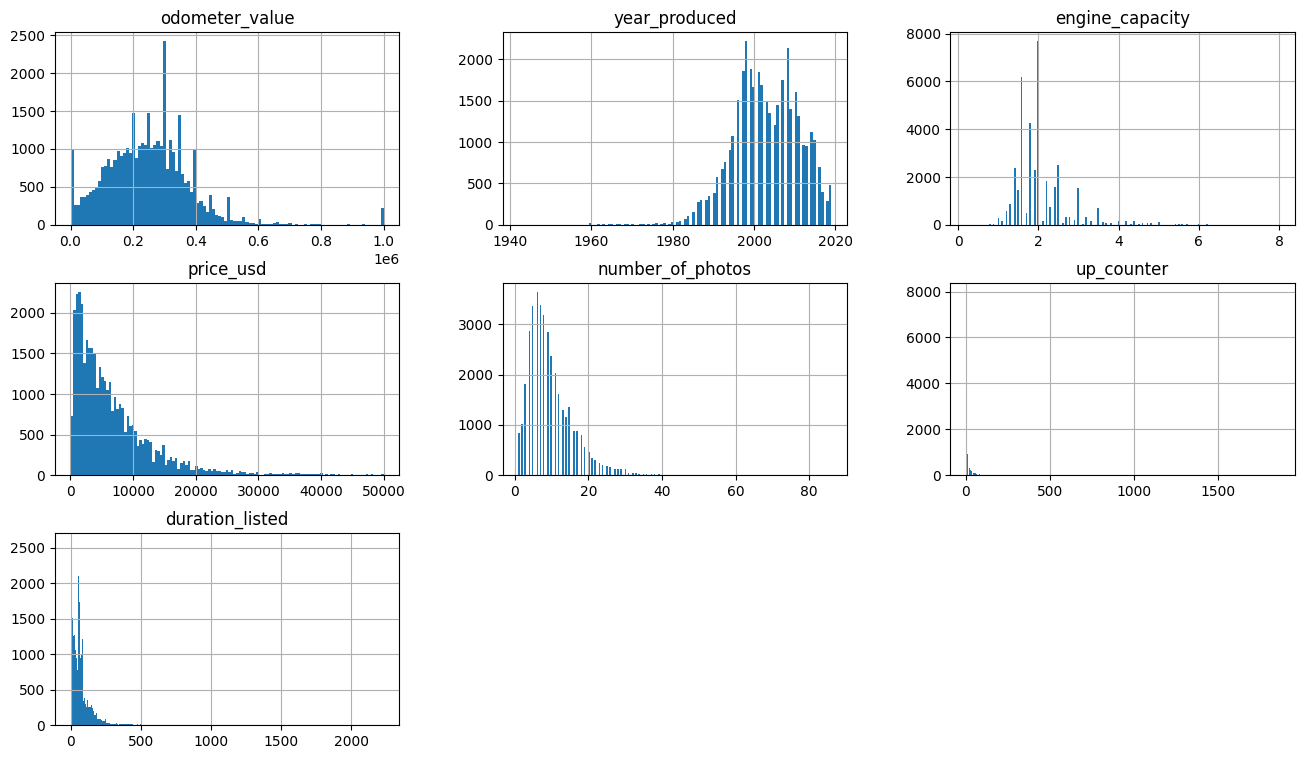

In [ ]:
df.hist(bins='auto', figsize=(16,9), layout=(3,3));

In [ ]:
df["odometer_value"].value_counts().sort_index(ascending=False).head()

odometer_value
1000000    162
999999      55
999998       1
996566       1
987654       1
Name: count, dtype: int64

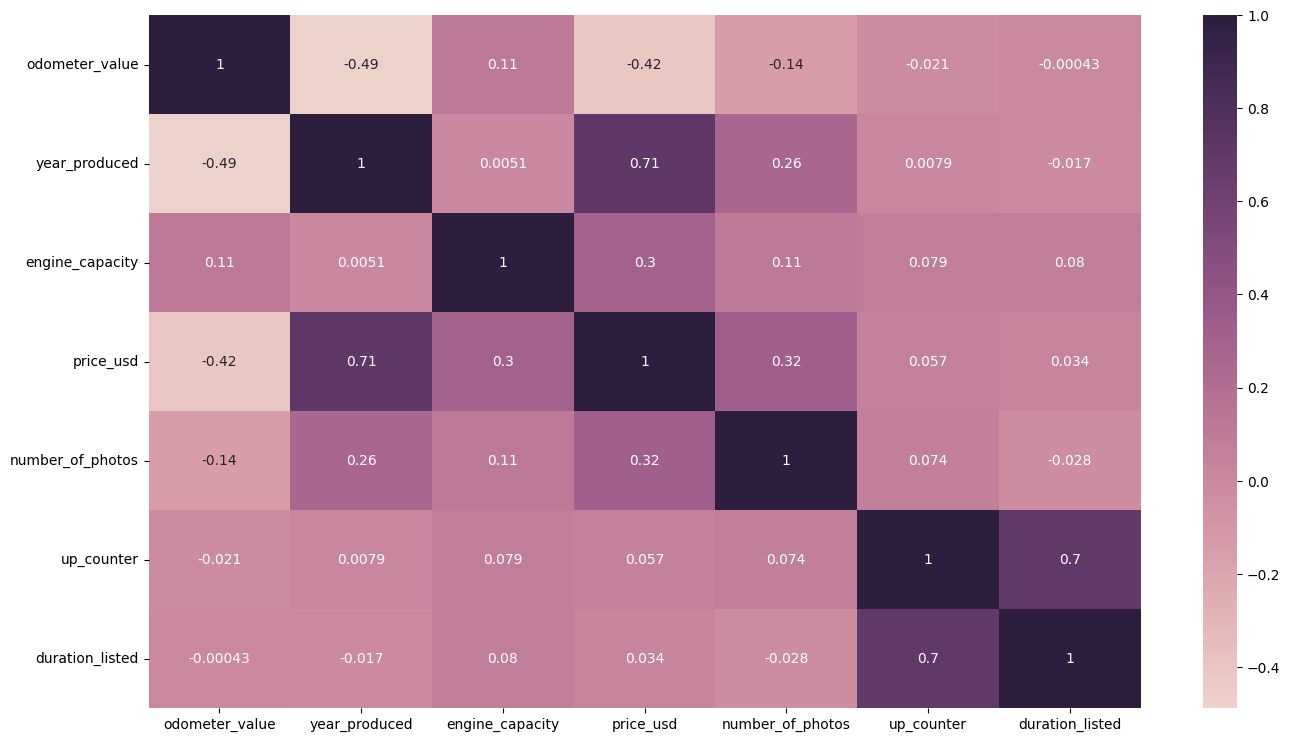

In [ ]:
plt.figure(figsize=(16,9))
sns.heatmap(df.select_dtypes(include=['float64', 'int64']).corr(), cmap=sns.cubehelix_palette(as_cmap=True), annot=True)
plt.show()

## Análise do preço

In [ ]:
df["price_usd"].mean()

6639.971021255613

In [ ]:
df["price_usd"].std()

6428.1520182029035

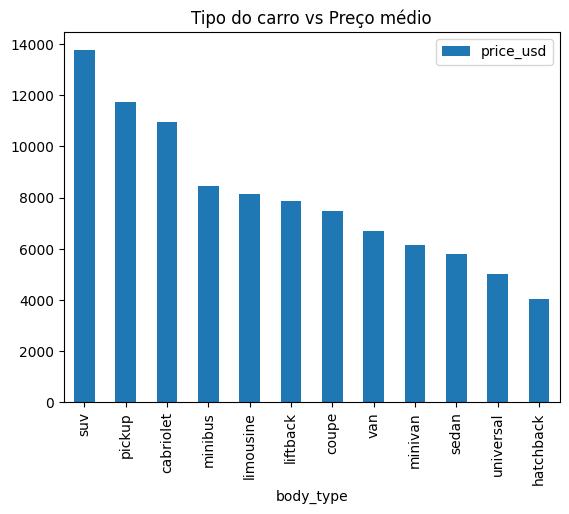

In [ ]:
df_cars_type = pd.DataFrame(df.groupby(['body_type'])['price_usd'].mean().sort_values(ascending = False))
df_cars_type.plot.bar()
plt.title('Tipo do carro vs Preço médio')
plt.show()

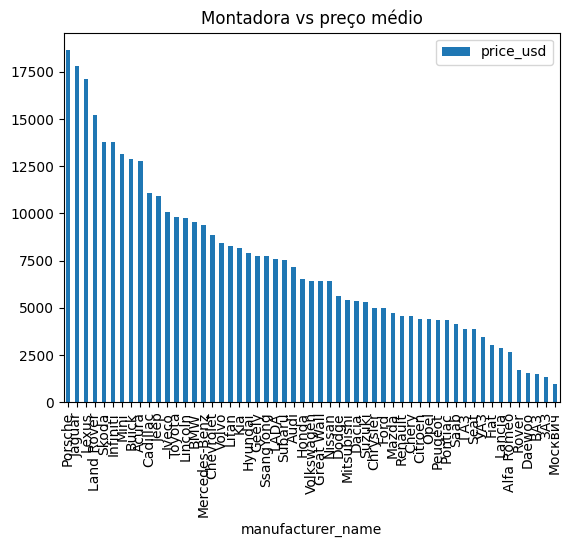

In [ ]:
df_manufacturer = pd.DataFrame(df.groupby(['manufacturer_name'])['price_usd'].mean().sort_values(ascending = False))
df_manufacturer.plot.bar()
plt.title('Montadora vs preço médio')
plt.show()

In [ ]:
df[df["price_usd"] <= df["price_usd"].mean() - df["price_usd"].std()].describe()

,odometer_value,year_produced,engine_capacity,price_usd,number_of_photos,up_counter,duration_listed
count,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000
mean,285054.839286,1990.285714,1.636607,156.027679,5.419643,15.169643,78.107143
std,249643.378794,5.692462,0.347707,55.920296,3.635754,38.922859,131.387698
min,1.000000,1963.000000,0.800000,1.000000,1.000000,1.000000,0.000000
25%,108250.000000,1987.000000,1.400000,149.000000,3.000000,1.000000,5.000000
50%,221000.000000,1991.000000,1.600000,167.890000,5.000000,2.000000,32.000000
75%,362293.750000,1994.000000,1.800000,200.000000,7.000000,9.000000,84.250000
max,1000000.000000,2008.000000,2.900000,210.000000,23.000000,294.000000,740.000000


In [ ]:
old_cars = df[df["year_produced"] == 1963]

In [ ]:
old_cars.min()

manufacturer_name             ГАЗ
model_name                     21
transmission           mechanical
color                       black
odometer_value                500
year_produced                1963
engine_fuel              gasoline
engine_has_gas              False
engine_type              gasoline
engine_capacity               1.4
body_type                   sedan
has_warranty                False
state                       owned
drivetrain                    all
price_usd                   189.7
is_exchangeable             False
location_region      Минская обл.
number_of_photos                3
up_counter                      3
feature_0                   False
feature_1                   False
feature_2                   False
feature_3                   False
feature_4                   False
feature_5                   False
feature_6                   False
feature_7                   False
feature_8                   False
feature_9                   False
duration_liste

In [ ]:
old_cars[old_cars["odometer_value"] == 500]

,manufacturer_name,model_name,transmission,color,odometer_value,year_produced,engine_fuel,engine_has_gas,engine_type,engine_capacity,...,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,duration_listed
23287,ГАЗ,69,mechanical,black,500,1963,gasoline,False,gasoline,2.4,...,False,False,False,False,False,False,False,True,False,413


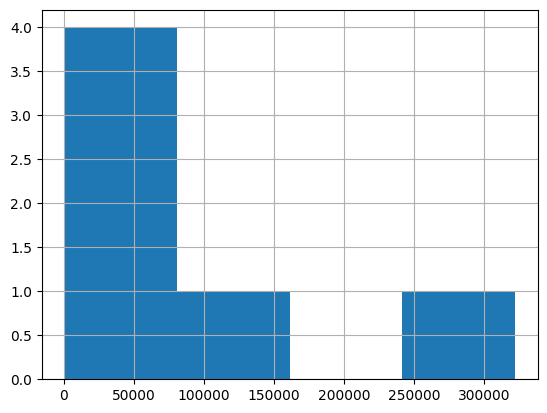

In [ ]:
old_cars["odometer_value"].hist(bins="auto");

Note que há carros do ano 1963 cujo odômetro mede 500 km. Isso chama atenção pois ou é mentira ou o motor do carro foi renovado. Note também (duas células anteriores) que o carro ficou listado por 413 dias.

## Distribuição das variáveis binárias

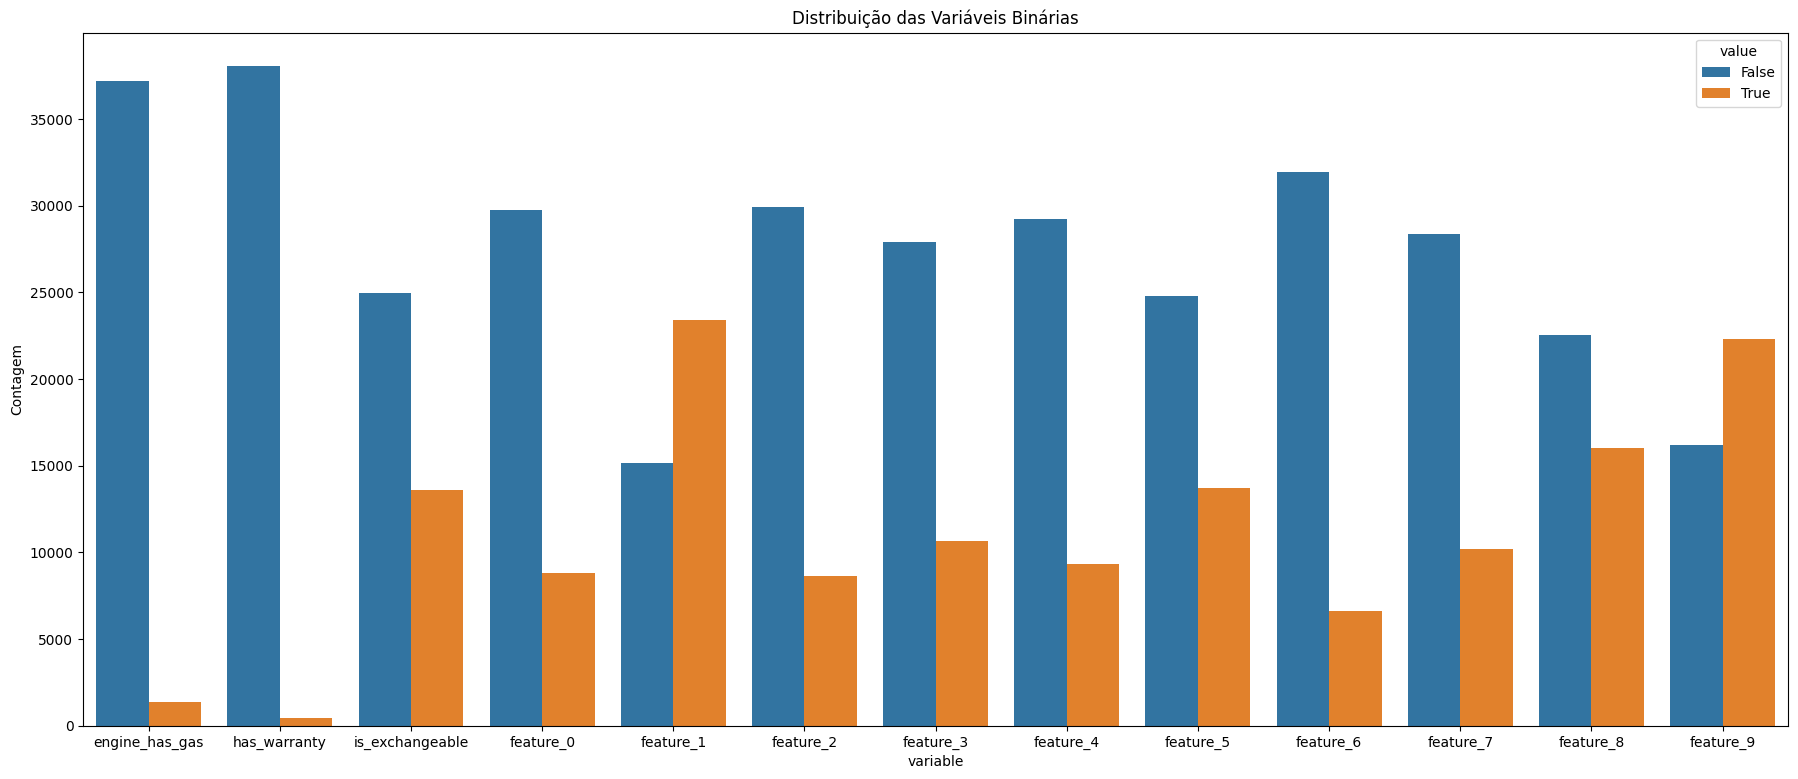

In [ ]:
bool_columns = df.select_dtypes(include='bool')
df_melted = bool_columns.melt(var_name="variable", value_name="value")

plt.figure(figsize=(22, 9))
sns.countplot(data=df_melted, x="variable", hue="value")
plt.title("Distribuição das Variáveis Binárias")
plt.ylabel("Contagem")
plt.show()

## Comentários

Assim como acontecido no dataset `California Housing`, aparentemente, este também "trunca" os valores em 1e6 km na coluna `odometer_value` quando esta ultrapassa o valor de 1e6 km. Por conta disto, considerei tais valores **errados**, e portanto, estes serão descartados em sequência.

É interessante notar também que o número de fotos, a capacidade do motor e o ano de fabricação apresentam maior coeficiente de correlação com o preço do veículo. Isso de fato faz sentido na vida prática quando pensso em olhar um carro por algum site.

Outro fato interessante de notar é a má formatação dos dados nas columnas `feature_4`, `feature_5`, `feature_6`, `feature_7`, `feature_8` e `feature_9`. Percebi que na columna `feature_4` tem uma linha cujo valor é *F* sendo que todas as outras são *False* ou *True*, portanto, interpretei esssa como *False*. Já nas outras columnas mencionadas, os valores encontrados são ou *False* ou *True*, portanto, transformer essas colunas para bool antes de mostrar a distribuição das variáveis binárias.

Em relação à análise do preço dos carros, é interessante notar que há veículos publicados na faixa de $150, o que é muito pouco considerando a nossa mentalidade brasileira; é no mínimo estranho. É possível perceber que são carros já bem velhos (mais de 30 anos em geral), poucas fotos publicadas (provavelmente pelo fato de que já não há tanta beleza ali, ou simplesmente por querer esconder defeitos físicos) e com muitos km rodados.

# Limpeza e separação dos dados

## Remoção dos dados duplicados

In [ ]:
df = df.drop_duplicates()

## Seleção do estado do carro

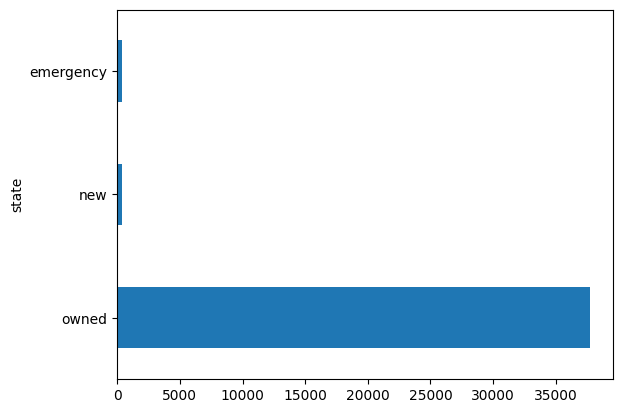

In [ ]:
df["state"].value_counts().plot(kind="barh");

In [ ]:
df = df[df['state'] == "owned"]

## Drop veículos cujo valor do odômetro superior a 1e6 km

In [ ]:
df = df[df["odometer_value"] < 999999]

## Seleciona os veículos com valor de listagem acima de $100

In [ ]:
df = df[df["price_usd"] >= 100]

## Cria duas novas colunas com base na transmissão e no tipo do motor

In [ ]:
df["is_transmission_automatic"] = df["transmission"].apply(lambda value: True if value == "automatic" else False)

In [ ]:
df["is_engine_type_diesel"] = df["engine_type"].apply(lambda value: True if value == "diesel" else False)

## Dropa carros raros (< 15 incidências)

In [ ]:
model_counts = df['model_name'].value_counts()
models_to_keep = model_counts[model_counts >= 15].index
df = df[df["model_name"].isin(models_to_keep)]

## Dropa as colunas `state`, `transmission`, `engine_type`, `duration_listed` e `number_of_photos`

In [ ]:
df = df.drop(columns=['state', 'transmission', 'engine_type', 'duration_listed', 'number_of_photos'])

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 34247 entries, 0 to 38530
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   manufacturer_name          34247 non-null  object 
 1   model_name                 34247 non-null  object 
 2   color                      34247 non-null  object 
 3   odometer_value             34247 non-null  int64  
 4   year_produced              34247 non-null  int64  
 5   engine_fuel                34247 non-null  object 
 6   engine_has_gas             34247 non-null  bool   
 7   engine_capacity            34247 non-null  float64
 8   body_type                  34247 non-null  object 
 9   has_warranty               34247 non-null  bool   
 10  drivetrain                 34247 non-null  object 
 11  price_usd                  34247 non-null  float64
 12  is_exchangeable            34247 non-null  bool   
 13  location_region            34247 non-null  object 


Neste momento, o dataset tem 34257 linhas e 27 colunas, como esperado

## Split dos dados

In [ ]:
df["price_cat"] = pd.qcut(df["price_usd"], q=10, labels=False)
X = df.drop(["price_usd", "price_cat"], axis=1)
y = df["price_usd"]
stratify_col = df["price_cat"]

In [ ]:
X_train_val, X_test, y_train_val, y_test, strat_train_val, strat_test = train_test_split(X, y, stratify_col, test_size=0.2, random_state=42, stratify=stratify_col)

In [ ]:
train_val_price_cat = pd.qcut(y_train_val, q=10, labels=False, duplicates='drop')

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=train_val_price_cat)

In [ ]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(X_val.shape, y_val.shape)

(20547, 26) (20547,)
(6850, 26) (6850,)
(6850, 26) (6850,)


In [ ]:
print("Percentage of train data: {} %".format(X_train.shape[0] / (X_train.shape[0] + X_test.shape[0] + X_val.shape[0])))
print("Percentage of test data: {} %".format(X_test.shape[0] / (X_train.shape[0] + X_test.shape[0] + X_val.shape[0])))
print("Percentage of val data: {} %".format(X_val.shape[0] / (X_train.shape[0] + X_test.shape[0] + X_val.shape[0])))

Percentage of train data: 0.5999649604344907 %
Percentage of test data: 0.2000175197827547 %
Percentage of val data: 0.2000175197827547 %


# EDA de treinamento

## 1. Variáveis numéricas (int e float)

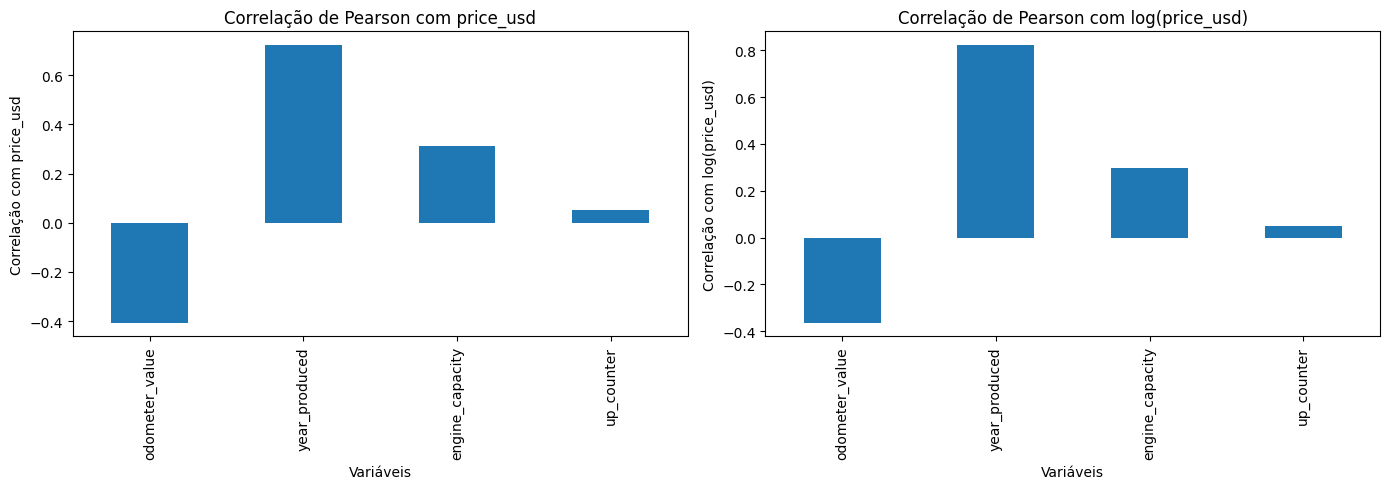

In [ ]:
numeric_columns_train = X_train.select_dtypes(include=["int64", "float64"])
correlation_matrix = numeric_columns_train.assign(price_usd=y_train).corr()
correlation_with_price = correlation_matrix['price_usd'].drop('price_usd')

log_price_usd = np.log1p(y_train)
correlation_matrix_log = numeric_columns_train.assign(log_price_usd=log_price_usd).corr()
correlation_with_log_price = correlation_matrix_log['log_price_usd'].drop('log_price_usd')

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

correlation_with_price.plot(kind='bar', ax=axes[0])
axes[0].set_title('Correlação de Pearson com price_usd')
axes[0].set_xlabel('Variáveis')
axes[0].set_ylabel('Correlação com price_usd')

correlation_with_log_price.plot(kind='bar', ax=axes[1])
axes[1].set_title('Correlação de Pearson com log(price_usd)')
axes[1].set_xlabel('Variáveis')
axes[1].set_ylabel('Correlação com log(price_usd)')

plt.tight_layout()
plt.show()

## 2. Variáveis booleanas

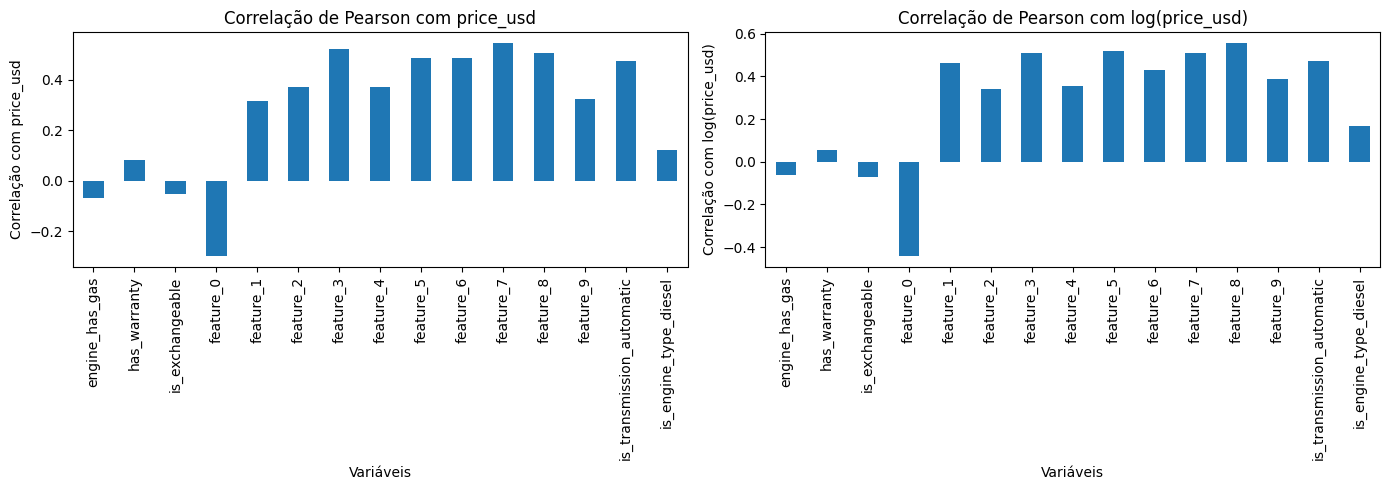

In [ ]:
bin_columns_train = X_train.select_dtypes(include=["bool"])
correlation_matrix = bin_columns_train.assign(price_usd=y_train).corr()
correlation_with_price = correlation_matrix['price_usd'].drop('price_usd')

log_price_usd = np.log1p(y_train)
correlation_matrix_log = bin_columns_train.assign(log_price_usd=log_price_usd).corr()
correlation_with_log_price = correlation_matrix_log['log_price_usd'].drop('log_price_usd')

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

correlation_with_price.plot(kind='bar', ax=axes[0])
axes[0].set_title('Correlação de Pearson com price_usd')
axes[0].set_xlabel('Variáveis')
axes[0].set_ylabel('Correlação com price_usd')

correlation_with_log_price.plot(kind='bar', ax=axes[1])
axes[1].set_title('Correlação de Pearson com log(price_usd)')
axes[1].set_xlabel('Variáveis')
axes[1].set_ylabel('Correlação com log(price_usd)')

plt.tight_layout()
plt.show()

## Comentários

Ao calcular a correlação com o logaritmo do preço, é comum observar mudanças nas magnitudes das correlações. Isso ocorre porque o logaritmo pode transformar relações exponenciais ou de ordem de grandeza em relações mais lineares, tornando-se mais adequado para identificar relações lineares ocultas entre as variáveis e a variável de preço. Portanto, se observar uma correlação significativamente diferente (geralmente mais forte) com o logaritmo do preço, isso pode indicar que a relação entre a variável e o preço é exponencial ou que o uso do logaritmo ajuda a linearizar a relação.

Em relação às variáveis numéricas, é interessante notar que a variável `year_produced` pode ter uma relação exponencial com o preço do veículo.

Já em relação às variáveis binárias, me chamou a atenção do significativo aumento no módulo da correlação entre a variável `feature_0` e o preço. No caso, conclui-se pode existir uma relação exponencial negativa. A variável `feature_1` apresenta o mesmo comportamento, porém, para o lado positivo da correlação.

## 3. Variáveis categóricas

In [ ]:
categorical_columns = df.select_dtypes(include=["object"]).columns
len(categorical_columns)

7

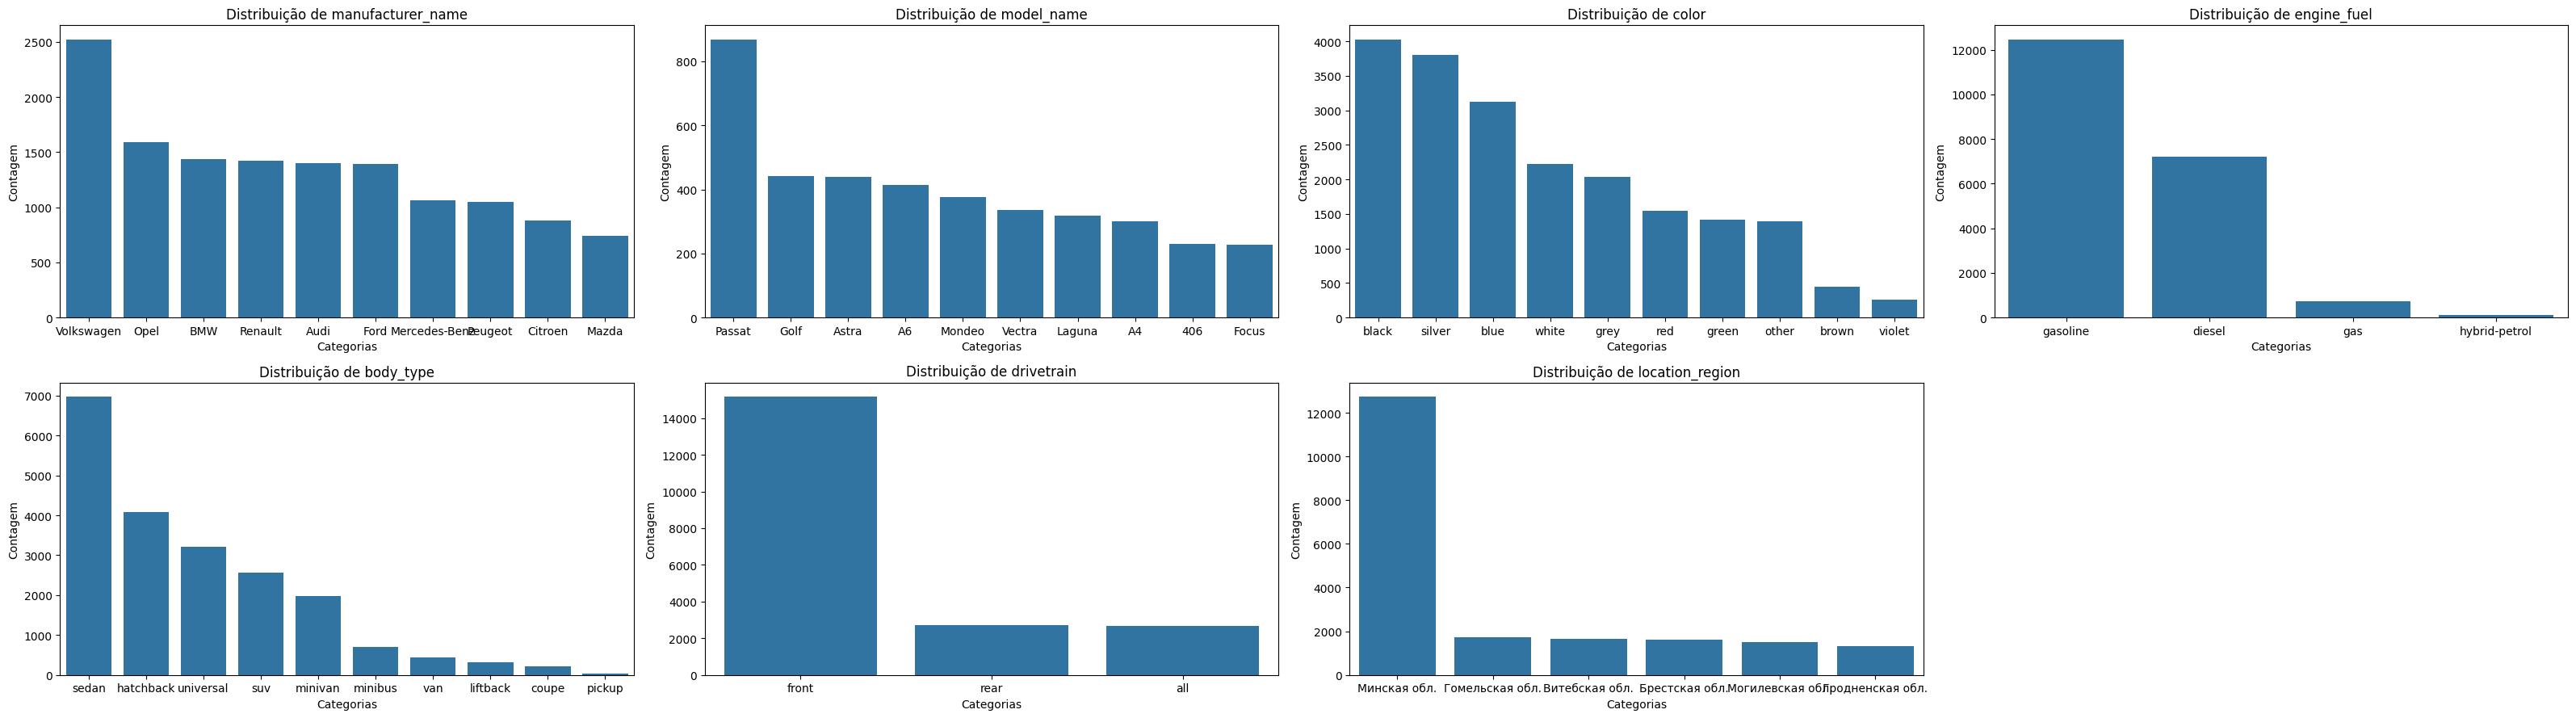

In [ ]:
n_cols = 4
n_rows = int(np.ceil(len(categorical_columns) / n_cols))

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(32, 9))

for idx, column in enumerate(categorical_columns):
  row = idx // n_cols
  col = idx % n_cols

  category_count = X_train[column].value_counts().nlargest(10)

  sns.barplot(x=category_count.index, y=category_count.values, ax=axes[row, col])
  axes[row, col].set_title(f'Distribuição de {column}')
  axes[row, col].set_xlabel('Categorias')
  axes[row, col].set_ylabel('Contagem')

  if idx == len(categorical_columns) - 1:
    for j in range(idx + 1, n_rows * n_cols):
      fig.delaxes(axes[j // n_cols, j % n_cols])

plt.tight_layout()
plt.show()

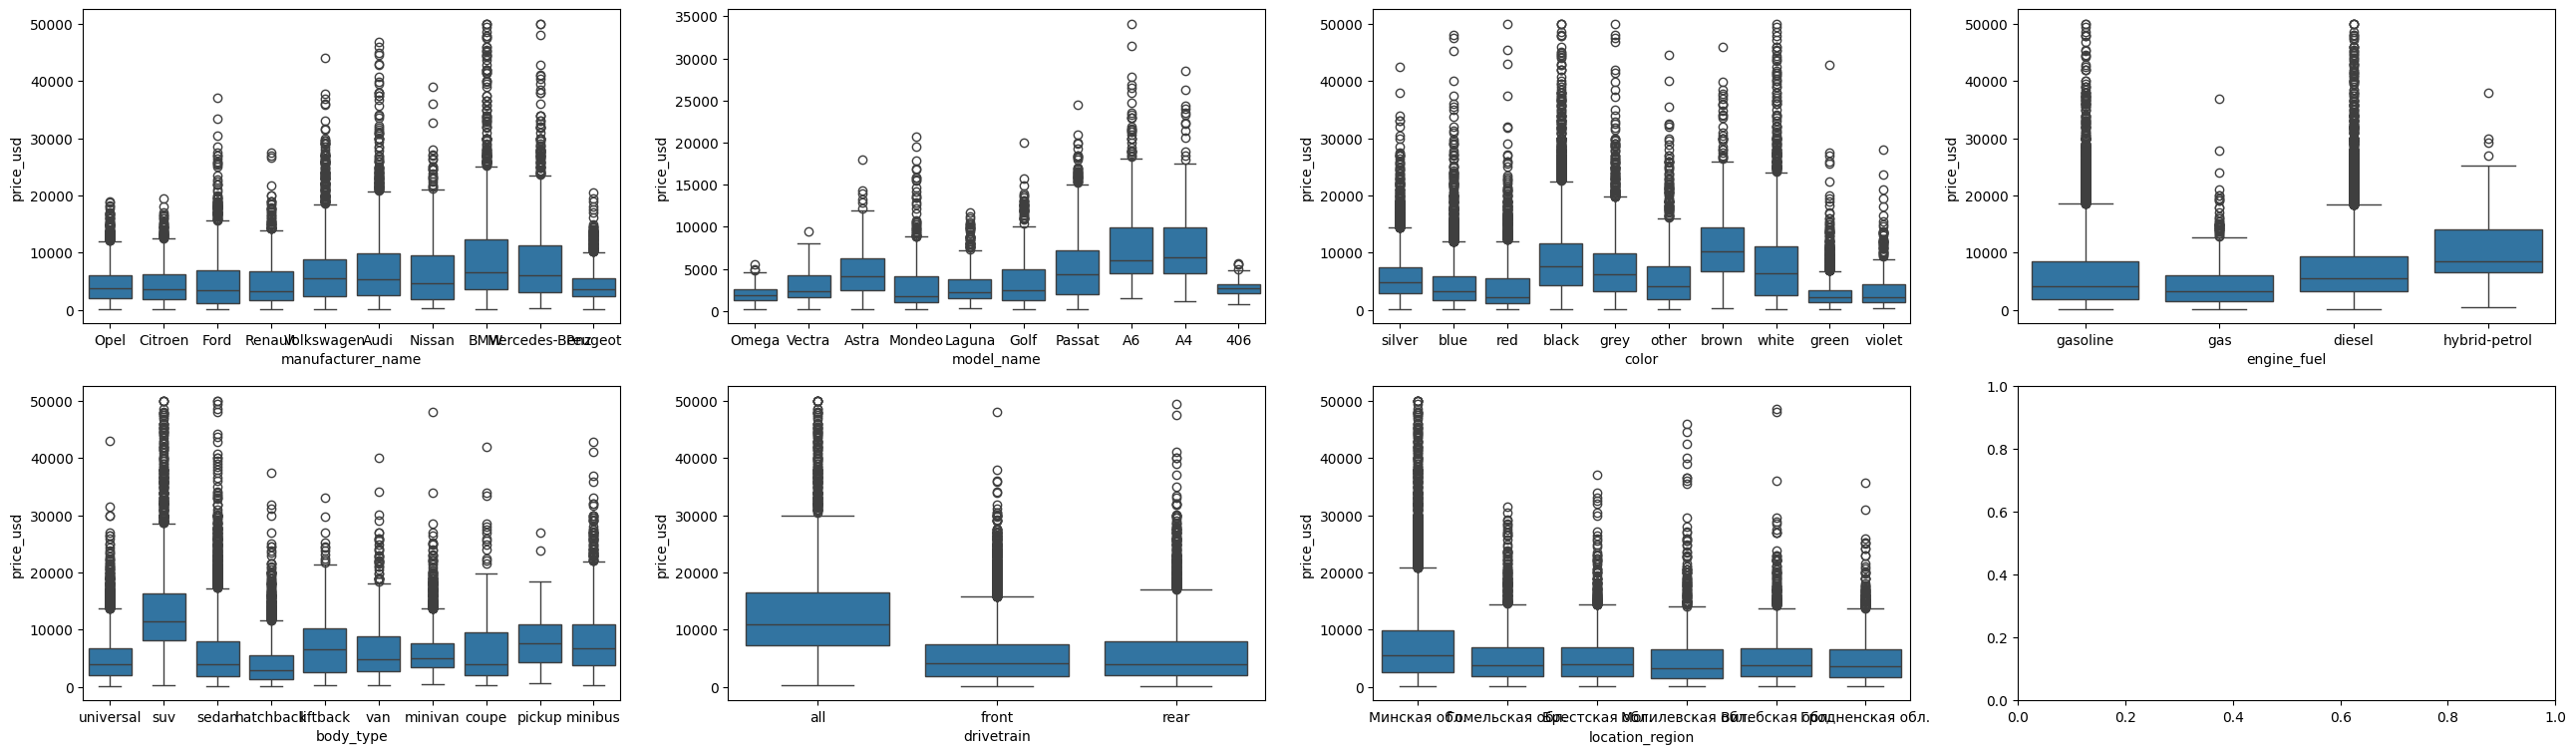

In [ ]:
n_cols = 4
n_rows = int(np.ceil(len(categorical_columns) / n_cols))

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(32, 9))

for idx, column in enumerate(categorical_columns):
  row = idx // n_cols
  col = idx % n_cols

  top_categories = df[column].value_counts().nlargest(10).index
  filtered_df = df[df[column].isin(top_categories)]

  sns.boxplot(data=filtered_df, x=column, y="price_usd", ax=axes[row, col])

plt.show()

# Seleção de hiperparâmetros

## 1. Pipeline com atributos numéricos

In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20547 entries, 16353 to 35979
Data columns (total 26 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   manufacturer_name          20547 non-null  object 
 1   model_name                 20547 non-null  object 
 2   color                      20547 non-null  object 
 3   odometer_value             20547 non-null  int64  
 4   year_produced              20547 non-null  int64  
 5   engine_fuel                20547 non-null  object 
 6   engine_has_gas             20547 non-null  bool   
 7   engine_capacity            20547 non-null  float64
 8   body_type                  20547 non-null  object 
 9   has_warranty               20547 non-null  bool   
 10  drivetrain                 20547 non-null  object 
 11  is_exchangeable            20547 non-null  bool   
 12  location_region            20547 non-null  object 
 13  up_counter                 20547 non-null  int6

In [ ]:
numeric_columns = X_train.select_dtypes(include=["float64", "int64"]).columns

In [ ]:
numeric_columns

Index(['odometer_value', 'year_produced', 'engine_capacity', 'up_counter'], dtype='object')

In [ ]:
preprocessor = ColumnTransformer(transformers=[("num", "passthrough", numeric_columns.tolist())])

In [ ]:
regression_pipeline = Pipeline(steps=[("preprocessor", preprocessor), ("regressor", LinearRegression())])

In [ ]:
regression_pipeline.fit(X_train, y_train)
print(f'Train RMSE: {root_mean_squared_error(y_train, regression_pipeline.predict(X_train)):.2f}')
print(f'Train MAPE: {mean_absolute_percentage_error(y_train, regression_pipeline.predict(X_train)):.1%}')
print(f'Val RMSE: {root_mean_squared_error(y_val, regression_pipeline.predict(X_val)):.2f}')
print(f'Val MAPE: {mean_absolute_percentage_error(y_val, regression_pipeline.predict(X_val)):.1%}')

Train RMSE: 3461.84
Train MAPE: 77.1%
Val RMSE: 3397.54
Val MAPE: 77.9%


Adicionando o StandardScaler

In [ ]:
preprocessor = ColumnTransformer(transformers=[("num", StandardScaler(), numeric_columns.tolist())])
regression_pipeline = Pipeline(steps=[("preprocessor", preprocessor), ("regressor", LinearRegression())])

regression_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

regression_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['odometer_value',
                                                   'year_produced',
                                                   'engine_capacity',
                                                   'up_counter'])])),
                ('regressor', LinearRegression())])

In [ ]:
print(f'Train RMSE: {root_mean_squared_error(y_train, regression_pipeline.predict(X_train)):.2f}')
print(f'Train MAPE: {mean_absolute_percentage_error(y_train, regression_pipeline.predict(X_train)):.1%}')
print(f'Val RMSE: {root_mean_squared_error(y_val, regression_pipeline.predict(X_val)):.2f}')
print(f'Val MAPE: {mean_absolute_percentage_error(y_val, regression_pipeline.predict(X_val)):.1%}')

Train RMSE: 3461.84
Train MAPE: 77.1%
Val RMSE: 3397.54
Val MAPE: 77.9%


Como é possível ver, não houve qualquer diferença no resultado, o que me parece muito estranho, contudo, não sei explicar o porquê.

## 2. Pipeline com atributos booleanos

In [ ]:
columns = X_train.select_dtypes(include=["bool"]).columns

preprocessor = ColumnTransformer(transformers=[("bool", OneHotEncoder(drop="if_binary"), columns.tolist())])
regression_pipeline = Pipeline(steps=[("preprocessor", preprocessor), ("regressor", LinearRegression())])

regression_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

regression_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('bool',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['engine_has_gas',
                                                   'has_warranty',
                                                   'is_exchangeable',
                                                   'feature_0', 'feature_1',
                                                   'feature_2', 'feature_3',
                                                   'feature_4', 'feature_5',
                                                   'feature_6', 'feature_7',
                                                   'feature_8', 'feature_9',
                                                   'is_transmission_automatic',
                                                   'is_engine_type_diesel'])])),
                ('regressor', LinearRegression())])

In [ ]:
print(f'Train RMSE: {root_mean_squared_error(y_train, regression_pipeline.predict(X_train)):.2f}')
print(f'Train MAPE: {mean_absolute_percentage_error(y_train, regression_pipeline.predict(X_train)):.1%}')
print(f'Val RMSE: {root_mean_squared_error(y_val, regression_pipeline.predict(X_val)):.2f}')
print(f'Val MAPE: {mean_absolute_percentage_error(y_val, regression_pipeline.predict(X_val)):.1%}')

Train RMSE: 4074.97
Train MAPE: 81.1%
Val RMSE: 4095.09
Val MAPE: 82.9%


## Pipeline com atributos categóricos

In [ ]:
columns = X_train.select_dtypes(include=["object"]).columns

preprocessor = ColumnTransformer(transformers=[("cat", OneHotEncoder(), columns.tolist())])
regression_pipeline = Pipeline(steps=[("preprocessor", preprocessor), ("regressor", LinearRegression())])

regression_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

regression_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat', OneHotEncoder(),
                                                  ['manufacturer_name',
                                                   'model_name', 'color',
                                                   'engine_fuel', 'body_type',
                                                   'drivetrain',
                                                   'location_region'])])),
                ('regressor', LinearRegression())])

In [ ]:
print(f'Train RMSE: {root_mean_squared_error(y_train, regression_pipeline.predict(X_train)):.2f}')
print(f'Train MAPE: {mean_absolute_percentage_error(y_train, regression_pipeline.predict(X_train)):.1%}')
print(f'Val RMSE: {root_mean_squared_error(y_val, regression_pipeline.predict(X_val)):.2f}')
print(f'Val MAPE: {mean_absolute_percentage_error(y_val, regression_pipeline.predict(X_val)):.1%}')

Train RMSE: 3694.76
Train MAPE: 73.6%
Val RMSE: 3722.93
Val MAPE: 75.0%


## 4. Pipeline com todos os atributos

In [ ]:
numeric_columns = X_train.select_dtypes(include=["int64", "float64"]).columns
bool_columns = X_train.select_dtypes(include=["bool"]).columns
categorical_columns = X_train.select_dtypes(include=["object"]).columns

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(), categorical_columns),
        ("bool", OneHotEncoder(drop="if_binary"), bool_columns)
    ]
)

In [ ]:
regression_pipeline = Pipeline(steps=[("preprocessor", preprocessor), ("regressor", LinearRegression())])

In [ ]:
regression_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat', OneHotEncoder(),
                                                  Index(['manufacturer_name', 'model_name', 'color', 'engine_fuel', 'body_type',
       'drivetrain', 'location_region'],
      dtype='object')),
                                                 ('bool',
                                                  OneHotEncoder(drop='if_binary'),
                                                  Index(['engine_has_gas', 'has_warranty', 'is_exchangeable', 'feature_0',
       'feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5',
       'feature_6', 'feature_7', 'feature_8', 'feature_9',
       'is_transmission_automatic', 'is_engine_type_diesel'],
      dtype='object'))])),
                ('regressor', LinearRegression())])

In [ ]:
print(f'Train RMSE: {root_mean_squared_error(y_train, regression_pipeline.predict(X_train)):.2f}')
print(f'Train MAPE: {mean_absolute_percentage_error(y_train, regression_pipeline.predict(X_train)):.1%}')
print(f'Val RMSE: {root_mean_squared_error(y_val, regression_pipeline.predict(X_val)):.2f}')
print(f'Val MAPE: {mean_absolute_percentage_error(y_val, regression_pipeline.predict(X_val)):.1%}')

Train RMSE: 3195.55
Train MAPE: 55.4%
Val RMSE: 3266.02
Val MAPE: 57.4%


Nota-se uma melhoria significativa na métrica MAPE, fato que faz sentido uma vez que aumentamos a quantidade de colunas.

## 5. Polynomial Features

In [ ]:
numeric_columns = X_train.select_dtypes(include=["int64", "float64"]).columns
bool_columns = X_train.select_dtypes(include=["bool"]).columns
categorical_columns = X_train.select_dtypes(include=["object"]).columns

### Sem regularização

In [ ]:
@interact(d=(1, 20))
def create_and_evaluate_pipeline(d=1):
    """Create a pipeline applying polynomial features to numerical data."""
    numeric_columns = X_train.select_dtypes(include=["int64", "float64"]).columns
    bool_columns = X_train.select_dtypes(include=["bool"]).columns
    categorical_columns = X_train.select_dtypes(include=["object"]).columns

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', Pipeline(steps=[('poly', PolynomialFeatures(degree=d, include_bias=False)), ('scaler', StandardScaler())]), numeric_columns),
            ('cat', OneHotEncoder(), categorical_columns),
            ('bool', OneHotEncoder(drop="if_binary"), bool_columns)
        ]
    )

    # Pipeline
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', LinearRegression())
    ])

    # Treinamento e avaliação
    pipeline.fit(X_train, y_train)
    print(f'Train RMSE: {root_mean_squared_error(y_train, pipeline.predict(X_train)):.2f}')
    print(f'Train MAPE: {mean_absolute_percentage_error(y_train, pipeline.predict(X_train)):.1%}')
    print(f'Val RMSE: {root_mean_squared_error(y_val, pipeline.predict(X_val)):.2f}')
    print(f'Val MAPE: {mean_absolute_percentage_error(y_val, pipeline.predict(X_val)):.1%}')
    print()

interactive(children=(IntSlider(value=1, description='d', max=20, min=1), Output()), _dom_classes=('widget-int…

Percebe-se que, com a inserção de *PolynomialFeatures*, o modelo apresentou uma métrica melhor do que as anteriores no caso de $d ≤ 3$. Para os valores superiores a 4, percebe-se que o modelo apresenta *overfitting*.

### Com regularização

In [ ]:
@interact(d=(1, 10), alpha=FloatLogSlider(1e-20, min=-30, max=5, step=0.5, readout_format=".2e"))
def create_and_evaluate_pipeline(d=1, alpha=1e-10):
    """Create a pipeline applying polynomial features to numerical data."""
    numeric_columns = X_train.select_dtypes(include=["int64", "float64"]).columns
    bool_columns = X_train.select_dtypes(include=["bool"]).columns
    categorical_columns = X_train.select_dtypes(include=["object"]).columns

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', Pipeline(steps=[('poly', PolynomialFeatures(degree=d, include_bias=False)), ('scaler', StandardScaler())]), numeric_columns),
            ('cat', OneHotEncoder(), categorical_columns),
            ('bool', OneHotEncoder(drop="if_binary"), bool_columns)
        ]
    )

    # Pipeline
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', Ridge(alpha))
    ])

    # Treinamento e avaliação
    pipeline.fit(X_train, y_train)
    print(f'Train RMSE: {root_mean_squared_error(y_train, pipeline.predict(X_train)):.2f}')
    print(f'Train MAPE: {mean_absolute_percentage_error(y_train, pipeline.predict(X_train)):.1%}')
    print(f'Val RMSE: {root_mean_squared_error(y_val, pipeline.predict(X_val)):.2f}')
    print(f'Val MAPE: {mean_absolute_percentage_error(y_val, pipeline.predict(X_val)):.1%}')
    print()

interactive(children=(IntSlider(value=1, description='d', max=10, min=1), FloatLogSlider(value=1e-20, descript…

Após ter gastado um bom tempo procurando os hiperparâmetros, concluí quê $d = 6$ e $\alpha = 3.16 \cdot 10^{-17}$ dá um resultado melhor em comparação com outros valores.

## 6. TTR

In [ ]:
numeric_columns = X_train.select_dtypes(include=["int64", "float64"]).columns
bool_columns = X_train.select_dtypes(include=["bool"]).columns
categorical_columns = X_train.select_dtypes(include=["object"]).columns

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(), categorical_columns),
        ("bool", OneHotEncoder(drop="if_binary"), bool_columns)
    ]
)

In [ ]:
regression_pipeline = Pipeline(steps=[("preprocessor", preprocessor), ("regressor", TransformedTargetRegressor(LinearRegression(), func=np.log, inverse_func=np.exp))])
regression_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat', OneHotEncoder(),
                                                  Index(['manufacturer_name', 'model_name', 'color', 'engine_fuel', 'body_type',
       'drivetrain', 'location_region'],
      dtype='object')),
                                                 ('bool',
                                                  OneHotEncoder(drop='if_binary'),
                                                  Index(['engine_has_gas', 'has_warranty', 'is_exchangeable', 'feature_0',
       'feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5',
       'feature_6', 'feature_7', 'feature_8', 'feature_9',
       'is_transmission_automatic', 'is_engine_type_diesel'],
      dtype='object'))])),
                ('regressor',
                 TransformedTargetRegressor(func=<ufunc 'log'>,
                                            inverse_func=<ufunc 'exp'>,
                                            regressor=LinearRegression()))])

In [ ]:
print(f'Train RMSE: {root_mean_squared_error(y_train, regression_pipeline.predict(X_train)):.2f}')
print(f'Train MAPE: {mean_absolute_percentage_error(y_train, regression_pipeline.predict(X_train)):.1%}')
print(f'Val RMSE: {root_mean_squared_error(y_val, regression_pipeline.predict(X_val)):.2f}')
print(f'Val MAPE: {mean_absolute_percentage_error(y_val, regression_pipeline.predict(X_val)):.1%}')

Train RMSE: 3371.35
Train MAPE: 40.9%
Val RMSE: 3488.21
Val MAPE: 42.1%


## TTR + Poly + Ridge

In [ ]:
numeric_columns = X_train.select_dtypes(include=["int64", "float64"]).columns
bool_columns = X_train.select_dtypes(include=["bool"]).columns
categorical_columns = X_train.select_dtypes(include=["object"]).columns

In [ ]:
alpha = 3.16e-17
d = 6

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[('poly', PolynomialFeatures(degree=d, include_bias=False)), ('scaler', StandardScaler())]), numeric_columns),
        ('cat', OneHotEncoder(), categorical_columns),
        ('bool', OneHotEncoder(drop="if_binary"), bool_columns)
    ]
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', TransformedTargetRegressor(Ridge(alpha), func=np.log, inverse_func=np.exp))
])
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('poly',
                                                                   PolynomialFeatures(degree=6,
                                                                                      include_bias=False)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['odometer_value', 'year_produced', 'engine_capacity', 'up_counter'], dtype='object')),
                                                 ('cat', OneHotEncoder(),
                                                  Index(['manufacturer_name', 'model_name', 'color', 'engine_fuel', 'b...
                                                  Index(['engine_has_gas', 'has_warranty', 'is_exchangeable', 'feature_0',
       'feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5',
       'feature_6', 'feature_7', 'feature_8', 'feature_9',
       'is_transmission_automatic', 'is_engine_type_diesel'],
      dtype='object'))])),
                ('regressor',
                 TransformedTargetRegressor(func=<ufunc 'log'>,
                                            inverse_func=<ufunc 'exp'>,
                                            regressor=Ridge(alpha=3.16e-17)))])

In [ ]:
print(f'Train RMSE: {root_mean_squared_error(y_train, pipeline.predict(X_train)):.2f}')
print(f'Train MAPE: {mean_absolute_percentage_error(y_train, pipeline.predict(X_train)):.1%}')
print(f'Val RMSE: {root_mean_squared_error(y_val, pipeline.predict(X_val)):.2f}')
print(f'Val MAPE: {mean_absolute_percentage_error(y_val, pipeline.predict(X_val)):.1%}')

Train RMSE: 1562.01
Train MAPE: 21.2%
Val RMSE: 326407999.60
Val MAPE: 1663248.6%


Deste exercício, concluo *a priori* que aplicar Poly + L2 dá o melhor resultado.

Podemos perceber também o *overfitting* do modelo TTR + Poly + L2. Isso dá-se pelo fato de que o modelo é demasiadamente complexo para os dados inputados.

# Retreinamento

In [ ]:
X_train = pd.concat([X_train, X_val])
y_train = pd.concat([y_train, y_val])

In [ ]:
X_train.shape, y_train.shape

((27397, 26), (27397,))

In [ ]:
numeric_columns = X_train.select_dtypes(include=["int64", "float64"]).columns
bool_columns = X_train.select_dtypes(include=["bool"]).columns
categorical_columns = X_train.select_dtypes(include=["object"]).columns

In [ ]:
alpha = 3.16e-17
d = 6

In [ ]:
models = {
    "LR": Pipeline(
        steps=[
            (
                "preprocessor",
                ColumnTransformer(transformers=[("cat", OneHotEncoder(), categorical_columns), ("bool", OneHotEncoder(drop="if_binary"), bool_columns)]),
            ),
            ("regressor", LinearRegression()),
        ]
    ),
    "Poly+LR": Pipeline(
        steps=[
            (
                "preprocessor",
                ColumnTransformer(
                    transformers=[
                        ('num', Pipeline(steps=[('poly', PolynomialFeatures(degree=d, include_bias=False)), ('scaler', StandardScaler())]), numeric_columns),
                        ("cat", OneHotEncoder(), categorical_columns),
                        ("bool", OneHotEncoder(drop="if_binary"), bool_columns),
                    ]
                )
            ),
            ("regressor", LinearRegression()),
        ]
    ),
    "TTR": Pipeline(
        steps=[
            (
                "preprocessor",
                ColumnTransformer(transformers=[("cat", OneHotEncoder(), categorical_columns), ("bool", OneHotEncoder(drop="if_binary"), bool_columns)]),
            ),
            ("regressor", TransformedTargetRegressor(LinearRegression(), func=np.log, inverse_func=np.exp)),
        ]
    ),
    "TTR+Poly+Ridge": Pipeline(
        steps=[
            (
                "preprocessor",
                ColumnTransformer(
                    transformers=[
                        ('num', Pipeline(steps=[('poly', PolynomialFeatures(degree=d, include_bias=False)), ('scaler', StandardScaler())]), numeric_columns),
                        ("cat", OneHotEncoder(), categorical_columns),
                        ("bool", OneHotEncoder(drop="if_binary"), bool_columns),
                    ]
                )
            ),
            ("regressor", TransformedTargetRegressor(Ridge(alpha), func=np.log, inverse_func=np.exp)),
        ]
    ),
}

In [ ]:
results = pd.DataFrame([], columns=['Train RMSE', 'Train MAPE', 'Test RMSE', 'Test MAPE'])
for name, model in models.items():
    for (X, y, subset) in [(X_train, y_train, 'Train'), (X_test, y_test, 'Test')]:
        if subset == 'Train':
            model.fit(X, y)
        for (metric, abbrev) in [(root_mean_squared_error, 'RMSE'), (mean_absolute_percentage_error, 'MAPE')]:
            results.loc[name, f'{subset} {abbrev}'] = metric(y, model.predict(X))
results.style.format({'Train RMSE': '{:.2f}', 'Train MAPE': '{:.1%}',
                       'Test RMSE': '{:.2f}',  'Test MAPE': '{:.1%}'})

,Train RMSE,Train MAPE,Test RMSE,Test MAPE
LR,3200.56,55.7%,3371.27,57.7%
Poly+LR,1611.80,27.9%,4252.72,30.6%
TTR,3396.74,41.1%,3559.19,42.7%
TTR+Poly+Ridge,1567.40,21.3%,523489575721287350580812148678465476796531113422610490542695938711126350252474368.00,109052282179748377236030251151783636068777206006279259737284239970784245710848.0%


# Análise de resultados

Dado a tabela anterior, o melhor modelo entre os testados é que usa *Poly* + *Linear Regression*

## Scatter plot

In [ ]:
model = models["Poly+LR"]

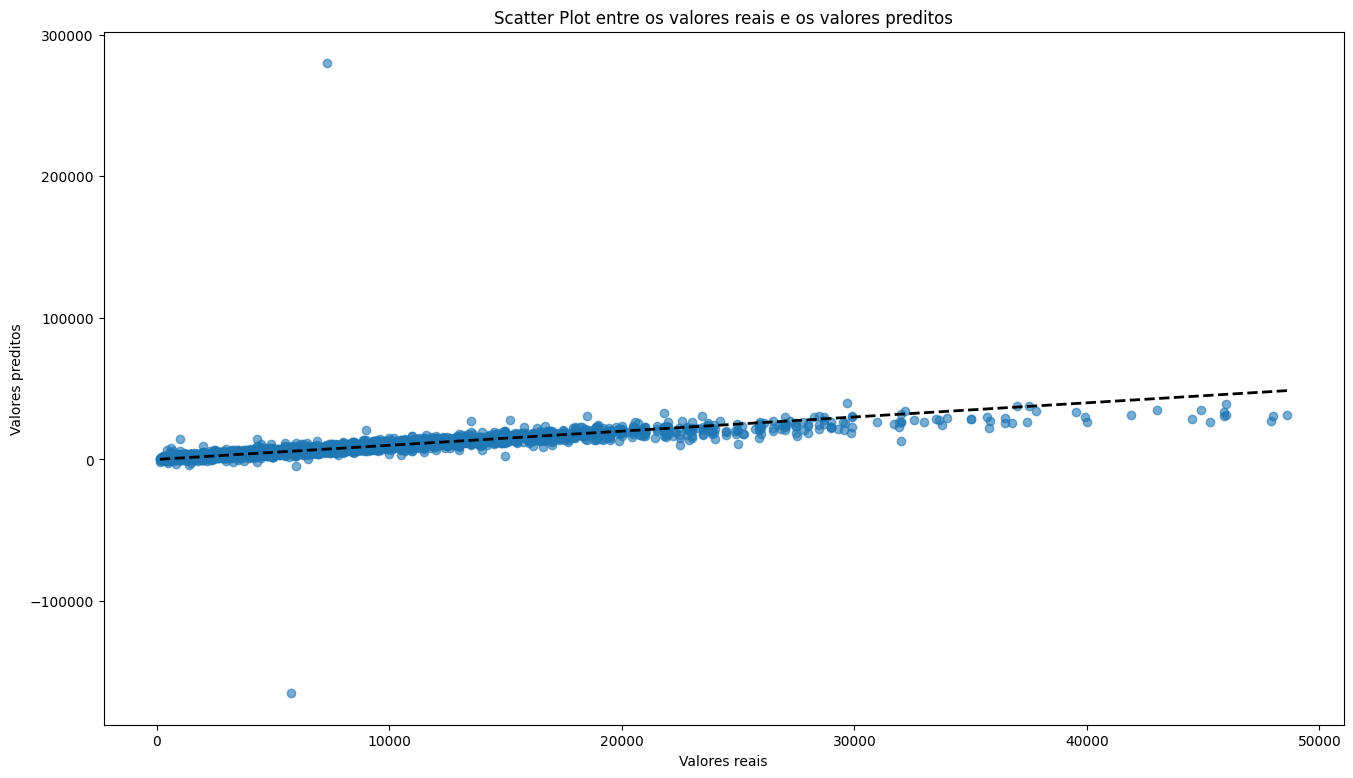

In [ ]:
plt.figure(figsize=(16, 9))
plt.scatter(y_test, model.predict(X_test), alpha=0.6)
plt.title("Scatter Plot entre os valores reais e os valores preditos")
plt.xlabel("Valores reais")
plt.ylabel("Valores preditos")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2);

In [ ]:
car_upper_than_30k__train = len(y_train[y_train > 30000])

In [ ]:
print(f"Percentagem de carros cujo valor é acima de $30k (treinamento): {car_upper_than_30k__train * 100 / len(y_train)} %")

Percentagem de carros cujo valor é acima de $30k (treinamento): 0.5657553746760594 %


Neste gráfico, a linha pontilhada representa os pontos nos quais os valores reais seriam iguais ao valores preditos. É possível perceber dois *outliers* bem evidentes na faixa dos \$6-8k, e também, é possível verificar que, a medida que o valor real aumenta, o modelo performa de modo pior. Isso pode ser explicado pelo fato de que há poucas amostras para treinamento de veículos cujo valor ultrapassa os \$30k (isso é verificado pela célula anterior).

## Distribuição de erro das predições

In [ ]:
err = model.predict(X_test) - y_test

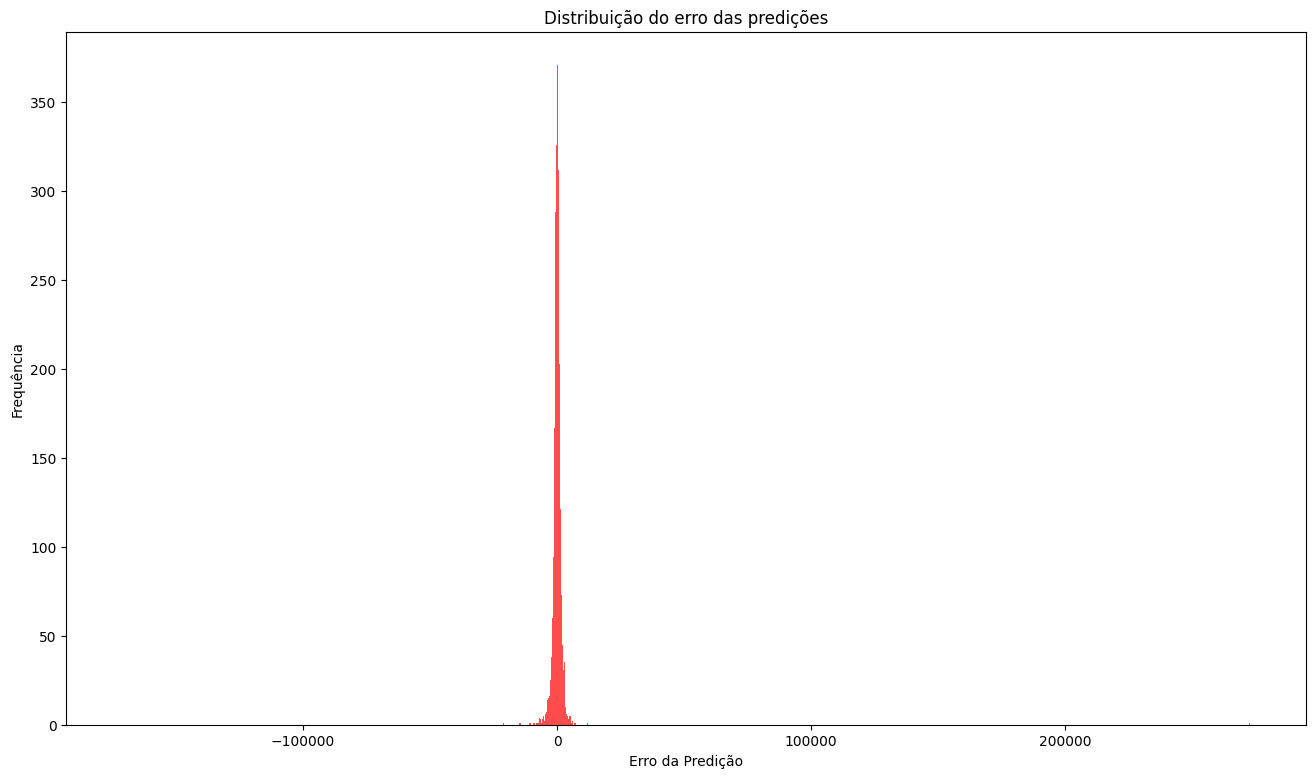

In [ ]:
plt.figure(figsize=(16, 9))
plt.hist(err, bins=int(len(y_test)/2), alpha=0.7, color='red')
plt.title('Distribuição do erro das predições')
plt.xlabel('Erro da Predição')
plt.ylabel('Frequência')
plt.show();

In [ ]:
print(f"Média do erro: {np.mean(err)}")
print(f"Desvio padrão do erro: {np.std(err)}")

Média do erro: -7.015234352189786
Desvio padrão do erro: 4252.715660762673


Idealmente, queremos que o erro seja simetricamente distribuído em torno do 0, o que significaria que o modelo não é sistematicamente enviesado. No caso do modelo desenvolvido, a média do erro foi medida em $\mu_{err} = \$-7.01$, o que pode ser interpretado como consideravelmente bom uma vez que 7 dólares por unidade de carro é um valor irrelevante dado o preço real de um automóvel. Contudo, analisar por essa métrica não é realista uma vez que o desvio padrão do erro foi medido em $\sigma_{err} = \$ 4252.7$.

Caso a métrica de avaliação fosse o *RMSE*, eu teria escolhido o modelo *LR*, o que não representaria corretamente a realidade.

# Conclusão

1. Considero o trabalho relativamente bem interessante, porém bem trabalhoso de ser compreendido aos detalhes, principalmente o item do *split* dos dados. Considero que aprendi bastante, principalmente com a análise dos dados (a qual expandi um pouco além do que foi pedido) e com o item 4.

2. Acredito que há sim algum viés nos dados do dataset pois na vida real ninguém compra carro pela internet (pelo menos na minha bolha de convivência), portanto, os preços listados não necessariamente refletem a realidade da venda de fato. Concluindo, o modelo desenvolvido já não apresentou uma performance pra lá de adequada, muito menos deveria ser empregado em produção.

3. Considero outros comentários feito ao longo do trabalho.